# LIBRARIES


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# INISIASI DATASET


In [11]:
# import
SENTIMENT_DATASET_FILE_NAME = "sentiment.csv"
SENTIMENT_DATASET_FILE_PATH = f"outputs/{SENTIMENT_DATASET_FILE_NAME}"
DATA_FRAME_SENTIMENT_DATASET = pd.read_csv(SENTIMENT_DATASET_FILE_PATH)
DATA_FRAME_SENTIMENT_DATASET_LENGTH = len(DATA_FRAME_SENTIMENT_DATASET)
print(f"labelled dataset: {DATA_FRAME_SENTIMENT_DATASET_LENGTH} tweets")
display(DATA_FRAME_SENTIMENT_DATASET.tail(1))
sentiment = DATA_FRAME_SENTIMENT_DATASET

labelled dataset: 4913 tweets


,user_id,username,user_display_name,tweet_id,full_text,created_at,cleaned_text,after_slang_text,underscore_negation_text,swap_negation_text,final_negation_text,is_different,after_stopwords_text,after_stemming_text,preprocessed_text,compound_score,sentiment_label
4912,1497098972443602944,RismaII4,Risma II 🇮🇩🇮🇩🇮🇩,1839477624550412418,Sebuah langkah besar menuju masa depan yang le...,Fri Sep 27 01:30:16 +0000 2024,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,False,langkah berkesinambungan inklusif dukungan pem...,langkah sambung inklusif dukung bangun kota ne...,langkah sambung inklusif dukung bangun kota ne...,-0.0192,negatif


# TF-IDF


In [12]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(sentiment["preprocessed_text"])

# SMOTE


In [13]:
smote = SMOTE(random_state=21)
X_smote, Y_smote = smote.fit_resample(X_tfidf, sentiment["sentiment_label"])

# DATA SPLIT (80% TRAIN, 20% TEST)


In [14]:
X_train,X_test,Y_train,Y_test=train_test_split(X_smote, Y_smote, test_size=0.2, random_state=21)

# KNN InSet


| k = 1 |
              precision    recall  f1-score   support

     negatif       0.97      0.45      0.61       589
      netral       0.74      1.00      0.85       624
     positif       0.82      0.95      0.88       613

    accuracy                           0.81      1826
   macro avg       0.84      0.80      0.78      1826
weighted avg       0.84      0.81      0.78      1826

| accuracy: 0.81 |
| precision: 0.8406074900198136 |
| recall: 0.8055859802847755 |
| f1: 0.7844962880557232 |


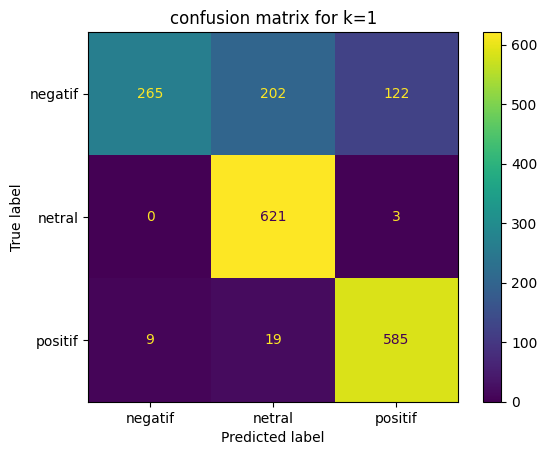

| k = 3 |
              precision    recall  f1-score   support

     negatif       0.99      0.37      0.54       589
      netral       0.69      1.00      0.81       624
     positif       0.82      0.94      0.88       613

    accuracy                           0.77      1826
   macro avg       0.83      0.77      0.74      1826
weighted avg       0.83      0.77      0.74      1826

| accuracy: 0.77 |
| precision: 0.8283665980554096 |
| recall: 0.7743702081051479 |
| f1: 0.7449057548589528 |


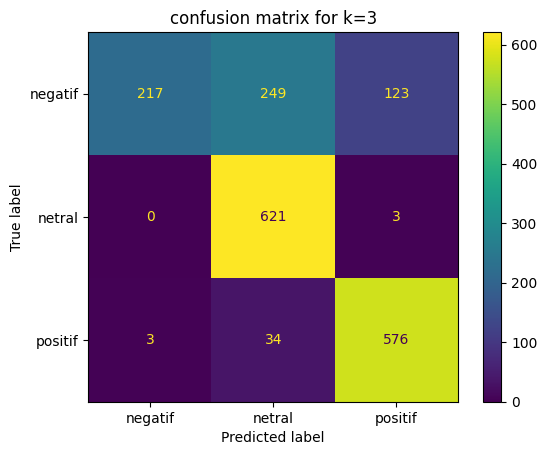

| k = 5 |
              precision    recall  f1-score   support

     negatif       0.97      0.33      0.49       589
      netral       0.65      0.99      0.79       624
     positif       0.83      0.92      0.87       613

    accuracy                           0.75      1826
   macro avg       0.82      0.75      0.72      1826
weighted avg       0.82      0.75      0.72      1826

| accuracy: 0.75 |
| precision: 0.8154923614792606 |
| recall: 0.7530120481927711 |
| f1: 0.7199728963769844 |


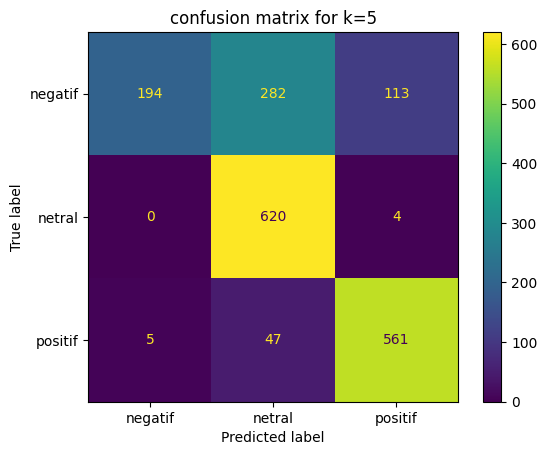

| k = 7 |
              precision    recall  f1-score   support

     negatif       0.98      0.31      0.47       589
      netral       0.63      0.99      0.77       624
     positif       0.83      0.90      0.86       613

    accuracy                           0.74      1826
   macro avg       0.82      0.73      0.70      1826
weighted avg       0.81      0.74      0.71      1826

| accuracy: 0.74 |
| precision: 0.8132169622167787 |
| recall: 0.7415115005476451 |
| f1: 0.7069370370741228 |


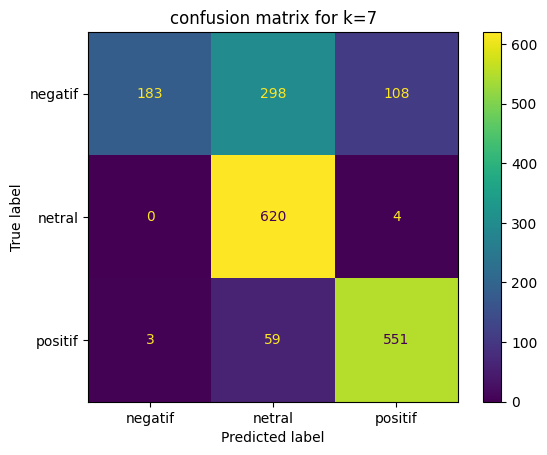

In [15]:
def train_evaluate_knn(k, X_train, Y_train, X_test, Y_test):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    print("===============================================================")
    print(f"| k = {k} |")
    print("===============================================================")
    print(classification_report(Y_test, y_pred, target_names=knn.classes_))
    print("===============================================================")
    
    print(f"| accuracy: {accuracy:.2f} |")
    print(f"| precision: {precision} |")
    print(f"| recall: {recall} |")
    print(f"| f1: {f1} |")
    print("===============================================================")
    cm = confusion_matrix(Y_test, y_pred, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
    disp.plot()
    plt.title(f"confusion matrix for k={k}")
    plt.show()
    
    return knn

knn1 = train_evaluate_knn(1, X_train, Y_train, X_test, Y_test)
knn3 = train_evaluate_knn(3, X_train, Y_train, X_test, Y_test)
knn5 = train_evaluate_knn(5, X_train, Y_train, X_test, Y_test)
knn7 = train_evaluate_knn(7, X_train, Y_train, X_test, Y_test)

# DUMP KNN MODEL AND TF-IDF VECTORIZER


In [16]:
def save_model(model, filename):
    with open(filename, 'wb') as model_file:
            joblib.dump(model, model_file)

# save_model(knn1, 'models/8020/knn1_8020_model.pkl')
# save_model(knn3, 'models/8020/knn3_8020_model.pkl')
# save_model(knn5, 'models/8020/knn5_8020_model.pkl')
# save_model(knn7, 'models/8020/knn7_8020_model.pkl')

# save_model(tfidf, 'models/tf-idf/tfidf_vectorizer.pkl')